In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import random
from math import sin
from functools import reduce

import numpy as np
import matplotlib.pyplot as plt
from toolz import iterate, take
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
from torch.nn import ModuleList as mdl
import torch.optim as optim
import torch.nn.functional as F
import tqdm

from wxml.mlp import MLP
from wxml.train import train
from wxml.evaluate import evaluate
from wxml.data import make_loader, make_splits

In [5]:
# functions to test
def parity(x):
    return x % 2


def compose(fs):
    def compose2(f, g):
        return lambda *a, **kw: f(g(*a, **kw))
    return reduce(compose2, fs)


# makes two-column dataset, first is data input to function of choice, second gets replaced w/ function output
def make_xs(n):
    return np.random.randint(0, 10, (n, 2))


# calls function of choice, f
def make_data(n, f, dtype=None):
    xs = make_xs(n) if dtype is None else make_xs(n).astype(dtype)
    xs[:, 1] = f(xs[:, 0])
    xs, ys = xs[:, 0], xs[:, 1]
    return xs, ys


# TODO: add batches
def make_data_parity(n, k=64):
    if isinstance(k, int):
        return make_data_parity(n, (0, k))
    else:
        xs = list(take(n, iterate(lambda _: random.randint(*k), random.randint(*k))))
        ys = list(map(parity, xs))

        xs = torch.tensor(xs, dtype=torch.float32, requires_grad=True)
        ys = torch.tensor(ys, dtype=torch.float32, requires_grad=True)
        ys = torch.unsqueeze(ys, 1)
        return xs, ys
    # xs_train, ys_train = make_data(n, parity)
    # xs_test, ys_test = make_data(n // 10, parity)
    # return xs_train, ys_train, xs_test, ys_test


def make_data_sin(n):
    xs_train, ys_train = make_data(n, np.sin, dtype=np.float32)
    xs_test, ys_test = make_data(n // 10, np.sin, dtype=np.float32)
    return xs_train, ys_train, xs_test, ys_test



def euclidean_distance(x, y):
    return torch.sqrt(torch.sum((x - y) ** 2))


def averager(f):
    return lambda x, y: f(x, y) / len(x)


batch_size = 32
n_batches = 256

assert batch_size * n_batches == 8192

n_test = 1024

xs, ys = make_data_parity(batch_size * n_batches)
xs_test_ood, ys_test_ood = make_data_parity(n_test, (65, 255))
# xs_test_ood, ys_test_ood = [torch.unsqueeze(x, 1) for x in [xs_test_ood, ys_test_ood]]

ds_train, ds_test = make_splits(xs, ys)

train_loader, test_loader = [DataLoader(d, batch_size=batch_size, shuffle=True) for d in [ds_train, ds_test]]
test_loader_ood = DataLoader(list(zip(xs_test_ood, ys_test_ood)), batch_size=batch_size, shuffle=False)

In [ ]:
num_layers = 2
input_dim = 1
hidden_dim = 32
output_dim = 1

lr = 1e-3

epochs = 50

model = MLP(num_layers, input_dim, hidden_dim, output_dim)
opt = optim.Adam(model.parameters(), lr=lr)
loss_fn = F.binary_cross_entropy

results = train(model, loss_fn, opt, train_loader, test_loader, epochs=epochs, device='mps', dtype=torch.float32, print_every=n_batches // 10)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch=0 | train_loss=2.9622 | val_loss=0.7124 | train_acy=0.5002 | val_acy=0.5009
epoch=1 | train_loss=0.7107 | val_loss=0.7128 | train_acy=0.4982 | val_acy=0.5009
epoch=2 | train_loss=0.7103 | val_loss=0.7118 | train_acy=0.4981 | val_acy=0.5009
epoch=3 | train_loss=0.7099 | val_loss=0.7123 | train_acy=0.4983 | val_acy=0.5009
epoch=4 | train_loss=0.7096 | val_loss=0.7111 | train_acy=0.4981 | val_acy=0.5009
epoch=5 | train_loss=0.7093 | val_loss=0.7101 | train_acy=0.4981 | val_acy=0.5009
epoch=6 | train_loss=0.7089 | val_loss=0.7102 | train_acy=0.4982 | val_acy=0.5009
epoch=7 | train_loss=0.7085 | val_loss=0.7087 | train_acy=0.4984 | val_acy=0.5009
epoch=8 | train_loss=0.7081 | val_loss=0.7101 | train_acy=0.4984 | val_acy=0.5009
epoch=9 | train_loss=0.7078 | val_loss=0.7096 | train_acy=0.4982 | val_acy=0.5009
epoch=10 | train_loss=0.7075 | val_loss=0.7069 | train_acy=0.4983 | val_acy=0.5009
epoch=11 | train_loss=0.7072 | val_loss=0.7093 | train_acy=0.4982 | val_acy=0.5009
epoch=12 | tra

In [7]:
num_layers = 2
input_dim = 1
hidden_dim = 32
output_dim = 1

lr = 1e-3

epochs = 50

model = MLP(num_layers, input_dim, hidden_dim, output_dim)
opt = optim.Adam(model.parameters(), lr=lr)
loss_fn = F.binary_cross_entropy

results_ood = train(model, loss_fn, opt, train_loader, test_loader_ood, epochs=epochs, device='mps', dtype=torch.float32, print_every=n_batches // 10)

  0%|          | 0/50 [00:00<?, ?it/s]

epoch=0 | train_loss=2.5736 | val_loss=28.8425 | train_acy=0.5015 | val_acy=0.5068
epoch=1 | train_loss=0.7423 | val_loss=35.5083 | train_acy=0.5041 | val_acy=0.5068
epoch=2 | train_loss=0.7255 | val_loss=31.6178 | train_acy=0.5060 | val_acy=0.5068
epoch=3 | train_loss=0.6961 | val_loss=27.9482 | train_acy=0.5081 | val_acy=0.5068
epoch=4 | train_loss=0.6905 | val_loss=27.9444 | train_acy=0.5175 | val_acy=0.5068
epoch=5 | train_loss=0.6905 | val_loss=27.9445 | train_acy=0.5054 | val_acy=0.5068
epoch=6 | train_loss=0.6886 | val_loss=27.9445 | train_acy=0.4962 | val_acy=0.5068
epoch=7 | train_loss=0.6884 | val_loss=27.9445 | train_acy=0.5080 | val_acy=0.5068
epoch=8 | train_loss=0.6871 | val_loss=27.9444 | train_acy=0.5119 | val_acy=0.5068
epoch=9 | train_loss=0.6880 | val_loss=27.9445 | train_acy=0.4975 | val_acy=0.5068
epoch=10 | train_loss=0.6870 | val_loss=27.9445 | train_acy=0.4928 | val_acy=0.5068
epoch=11 | train_loss=0.6869 | val_loss=27.9484 | train_acy=0.4974 | val_acy=0.5068
ep

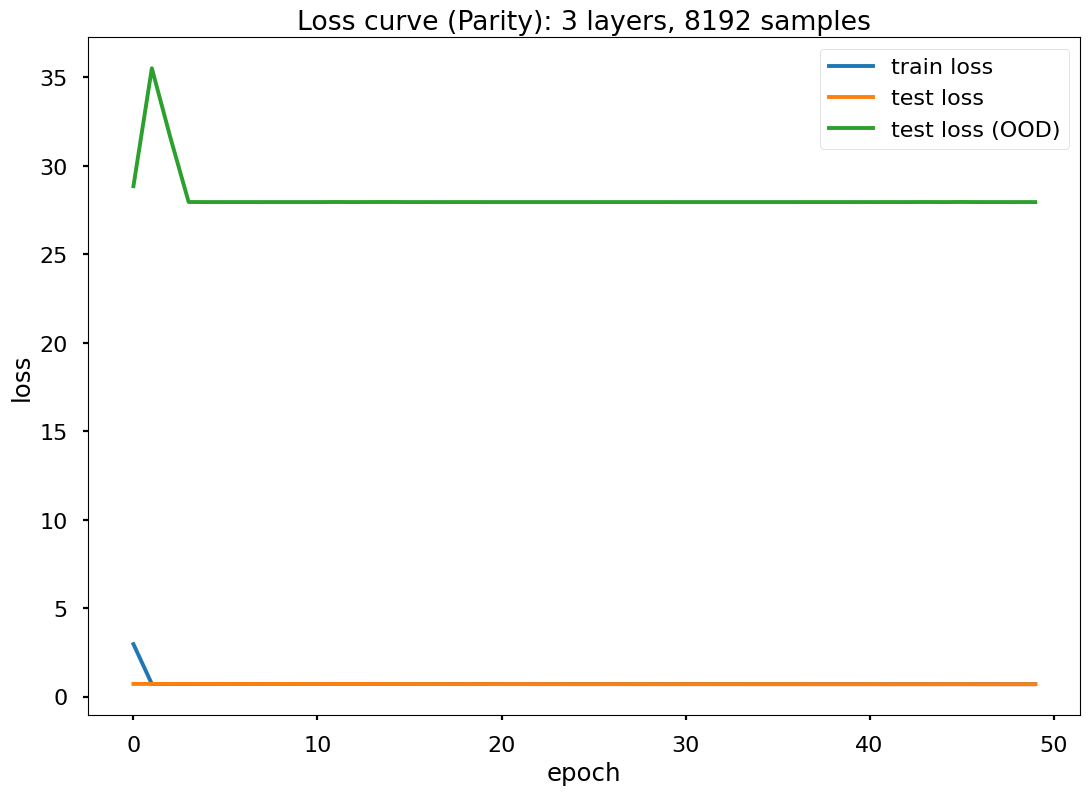

In [8]:
plt.style.use('seaborn-v0_8-poster')

plt.plot(results['train_losses'], label='train loss')
plt.plot(results['val_losses'], label='test loss')
plt.plot(results_ood['val_losses'], label='test loss (OOD)')
# plt.title("BCE Loss of 2-layer MLP on Hamming weight data using AdamW")
plt.title("Loss curve (Parity): 3 layers, 8192 samples")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

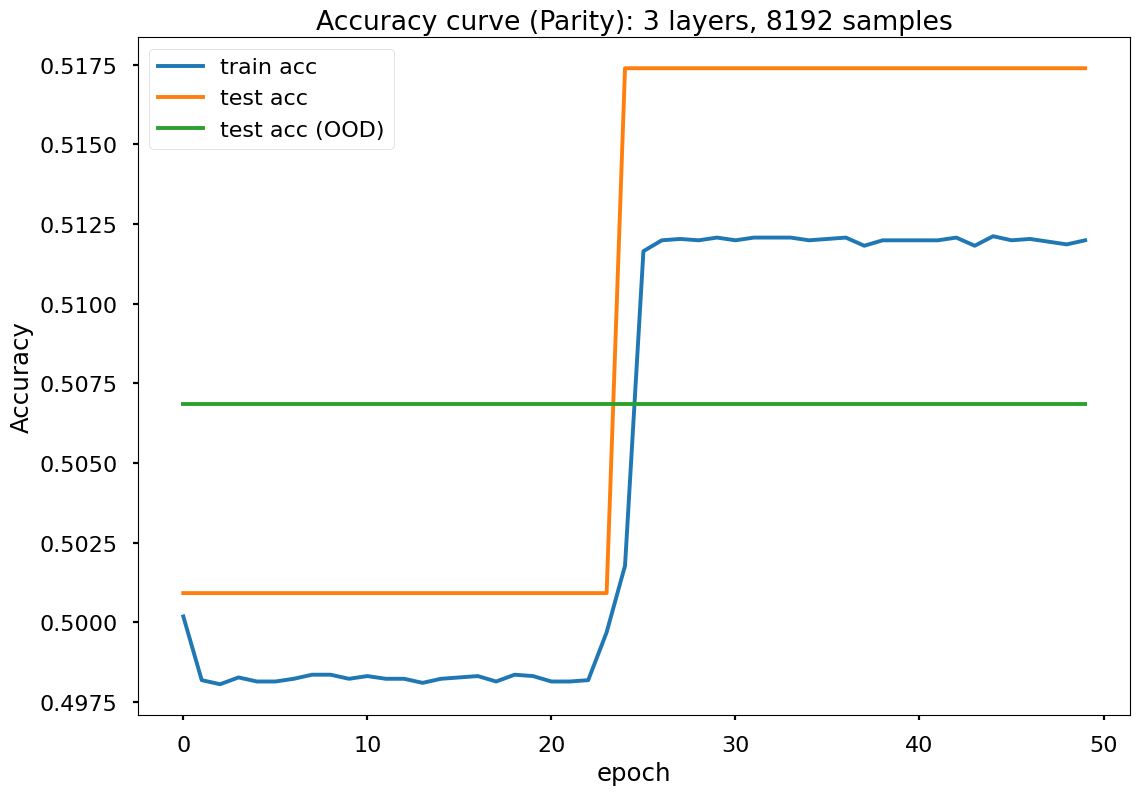

In [9]:
plt.style.use('seaborn-v0_8-poster')

plt.plot(results['train_accuracies'], label='train acc')
plt.plot(results['val_accuracies'], label='test acc')
plt.plot(results_ood['val_accuracies'], label='test acc (OOD)')
plt.title("Accuracy curve (Parity): 3 layers, 8192 samples")
plt.ylabel("Accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

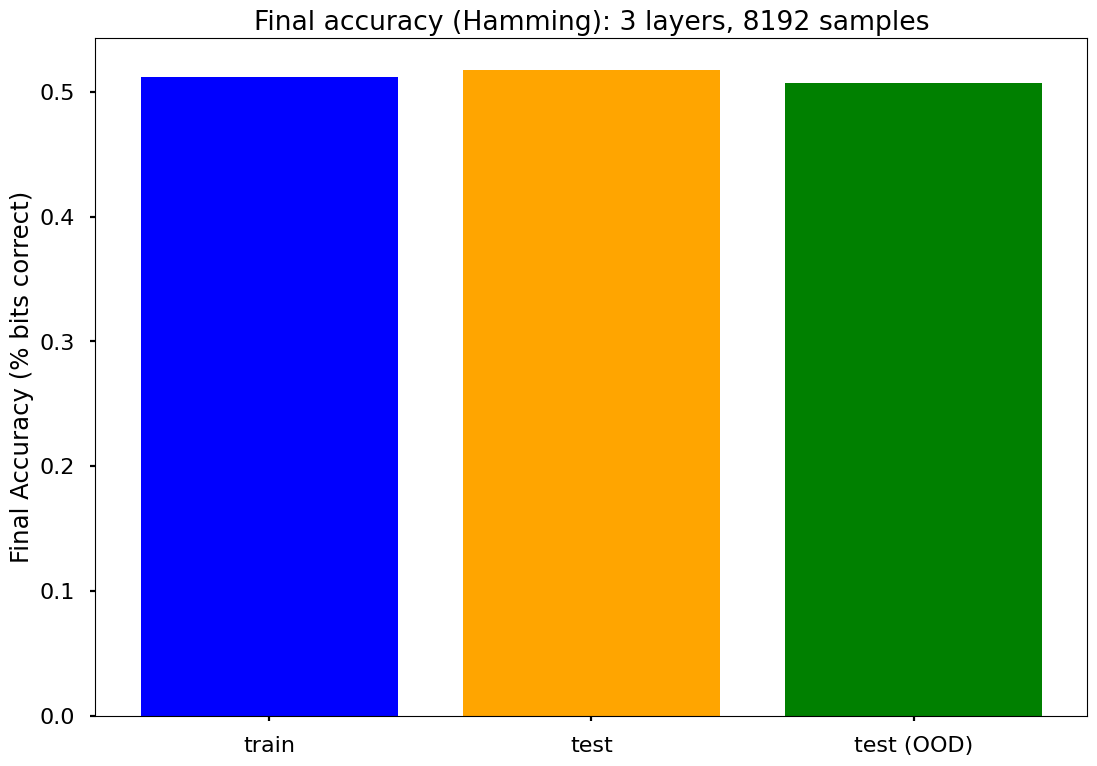

In [10]:
plt.style.use('seaborn-v0_8-poster')

final_train_acc = results['train_accuracies'][-1]
final_test_acc = results['val_accuracies'][-1]
final_test_ood_acc = results_ood['val_accuracies'][-1]

plt.bar(['train', 'test', 'test (OOD)'], [final_train_acc, final_test_acc, final_test_ood_acc], color=['blue', 'orange', 'green'])
plt.ylabel("Final Accuracy (% bits correct)")
plt.title("Final accuracy (Hamming): 3 layers, 8192 samples")
plt.show()

In [ ]:
def round(x):
    if x >= 0.5: x = 1
    else: x = 0
    return x

print(xs_test_parity[:5], ys_test_parity[:5])
# Convert test data into DataLoader
loader_test_parity = make_loader(xs_test_parity, ys_test_parity, batch_size=32)

# Evaluate the model
evaluate(model, averager(euclidean_distance), loader_test_parity, device=device)
